<a href="https://colab.research.google.com/github/prog815/progOrder/blob/main/%D0%A2%D1%80%D0%B5%D0%B9%D0%B4%D0%B8%D0%BD%D0%B3_%D0%9F%D1%80%D0%BE%D1%81%D1%82%D1%8B%D0%B5_%D0%BE%D1%80%D0%B4%D0%B5%D1%80%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [1]:
! pip install finam-export
! pip install git+https://github.com/prog815/progGA

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-k8lhc_rs
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-k8lhc_rs
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3732 sha256=b007fe6948d88829d953fa68973d0b9a0fdd352a2ec4b5e27a32032d441b4926
  Stored in directory: /tmp/pip-ephem-wheel-cache-_8ah48y_/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA


In [2]:
from finam import Exporter, Market
import datetime
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
from progGA import ListGenetic
import pickle
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# Загрузка данных

In [3]:
exporter = Exporter()
sber = exporter.lookup(code='SBER', market=Market.SHARES)
data = exporter.download(sber.index[0],market=Market.SHARES,start_date=datetime.date(2008, 1, 1))
data.drop('<TIME>',axis=1,inplace=True)
data.set_index('<DATE>',inplace=True)
data.set_index(pd.to_datetime(data.index,format='%Y%m%d'),inplace=True)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562
2008-01-10,102.07,103.81,101.53,103.53,39745084
2008-01-11,103.60,105.45,102.86,104.70,32814608
2008-01-14,104.28,105.30,104.20,105.00,20709850
2008-01-15,105.20,106.60,104.80,105.71,51441473
...,...,...,...,...,...
2020-12-14,285.02,287.74,277.10,279.95,90216400
2020-12-15,278.53,283.76,276.07,278.70,84170420
2020-12-16,278.00,280.84,276.14,278.35,54712610


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3247 entries, 2008-01-09 to 2020-12-17
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   <OPEN>   3247 non-null   float64
 1   <HIGH>   3247 non-null   float64
 2   <LOW>    3247 non-null   float64
 3   <CLOSE>  3247 non-null   float64
 4   <VOL>    3247 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 152.2 KB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
<OPEN>,3247.0,1.237793e+02,6.462567e+01,13.80,78.74,97.79,1.824550e+02,2.850200e+02
<HIGH>,3247.0,1.253511e+02,6.517968e+01,14.49,79.88,98.80,1.854050e+02,2.877400e+02
<LOW>,3247.0,1.221230e+02,6.408988e+01,13.50,77.10,96.71,1.800900e+02,2.797800e+02
<CLOSE>,3247.0,1.237830e+02,6.467609e+01,14.16,78.61,97.70,1.831950e+02,2.837300e+02
<VOL>,3247.0,1.380493e+08,1.429130e+08,6414930.00,56022175.00,91691290.00,1.599995e+08,1.642064e+09


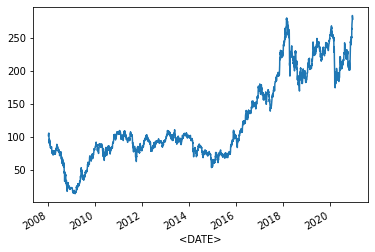

In [ ]:
data['<CLOSE>'].plot()

In [4]:
ohlc = data.values[:,:4]
d_ohlc = np.array(ohlc)
for n in range(1,len(ohlc)):
    b = ohlc[n-1,3]
    d_ohlc[n,:] = (ohlc[n,:] - b) / b
d_ohlc[0,:] = np.nan

data['dOpen'] = d_ohlc[:,0]
data['dHigh'] = d_ohlc[:,1]
data['dLow'] = d_ohlc[:,2]
data['dClose'] = d_ohlc[:,3]

data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,dOpen,dHigh,dLow,dClose
<DATE>,,,,,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562,NaN,NaN,NaN,NaN
2008-01-10,102.07,103.81,101.53,103.53,39745084,0.002160,0.019244,-0.003142,0.016495
2008-01-11,103.60,105.45,102.86,104.70,32814608,0.000676,0.018545,-0.006472,0.011301
2008-01-14,104.28,105.30,104.20,105.00,20709850,-0.004011,0.005731,-0.004776,0.002865
2008-01-15,105.20,106.60,104.80,105.71,51441473,0.001905,0.015238,-0.001905,0.006762
...,...,...,...,...,...,...,...,...,...
2020-12-14,285.02,287.74,277.10,279.95,90216400,0.004547,0.014133,-0.023367,-0.013323
2020-12-15,278.53,283.76,276.07,278.70,84170420,-0.005072,0.013610,-0.013860,-0.004465
2020-12-16,278.00,280.84,276.14,278.35,54712610,-0.002512,0.007679,-0.009186,-0.001256


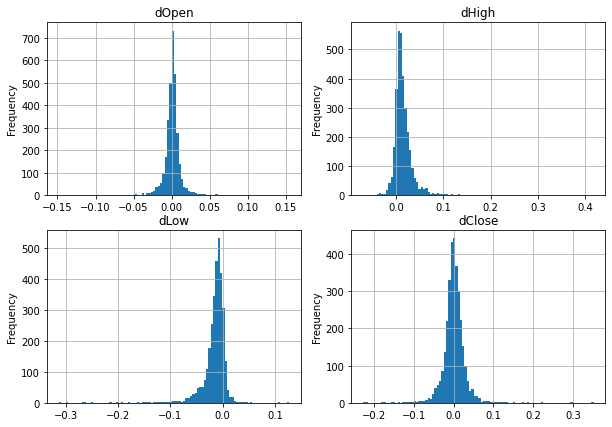

In [ ]:
plt.figure(figsize=(10,7))

for id,name in enumerate(['dOpen','dHigh','dLow','dClose']):
    plt.subplot(2,2,id+1)
    data[name].plot.hist(bins=100)
    plt.title(name)
    plt.grid()
plt.show()

# Функция расчета сигналов для ордеров

In [5]:
%%time

def getBuySellForData(ohlc, orderLifeLen = 50, dSL = 0.001, dTP = 0.0005, SP = 0.07):
    
    rows = ohlc.shape[0]

    Open = ohlc[:,0]
    Heigh = ohlc[:,1]
    Low = ohlc[:,2]
    Close = ohlc[:,3]

    buy = np.zeros_like(ohlc[:,0])
    sell = np.zeros_like(ohlc[:,0])

    for n in range(rows-1):
        
        OP = Close[n]

        buyTP = OP * ( 1. + dTP ) + SP
        buySL = OP * ( 1. - dSL ) + SP

        sellTP = OP * ( 1. - dTP ) - SP
        sellSL = OP * ( 1. + dSL ) - SP

        orderBuyOpened = False
        orderSellOpened = False

        orderBuyClosed = False
        orderSellClosed = False
        
        for k in range(n+1,min(n+orderLifeLen,rows)):
            
            if (not orderBuyOpened) and (Low[k] <= OP):
                orderBuyOpened = True

            if (not orderSellOpened) and (Heigh[k] >= OP):
                orderSellOpened = True

            if orderBuyOpened:
                if not orderBuyClosed:
                    if Heigh[k] >= buyTP:
                        orderBuyClosed = True
                        buy[n] = 1
                        
                    if Low[k] <= buySL:
                        orderBuyClosed = True
                        buy[n] = 0
            
            if orderSellOpened:
                if not orderSellClosed:
                    if Low[k] <= sellTP:
                        orderSellClosed = True
                        sell[n] = 1
                        
                    if Heigh[k] >= sellSL:
                        orderSellClosed = True
                        sell[n] = 0

    return buy,sell

b,s = getBuySellForData(ohlc,dSL=0.01)

CPU times: user 27.5 ms, sys: 0 ns, total: 27.5 ms
Wall time: 27.5 ms


In [ ]:
print(b)
print(s)
print(np.unique(b,return_counts=True))
print(np.unique(s,return_counts=True))

[1. 1. 1. ... 1. 1. 0.]
[0. 0. 1. ... 1. 0. 0.]
(array([0., 1.]), array([2066, 1181]))
(array([0., 1.]), array([2098, 1149]))


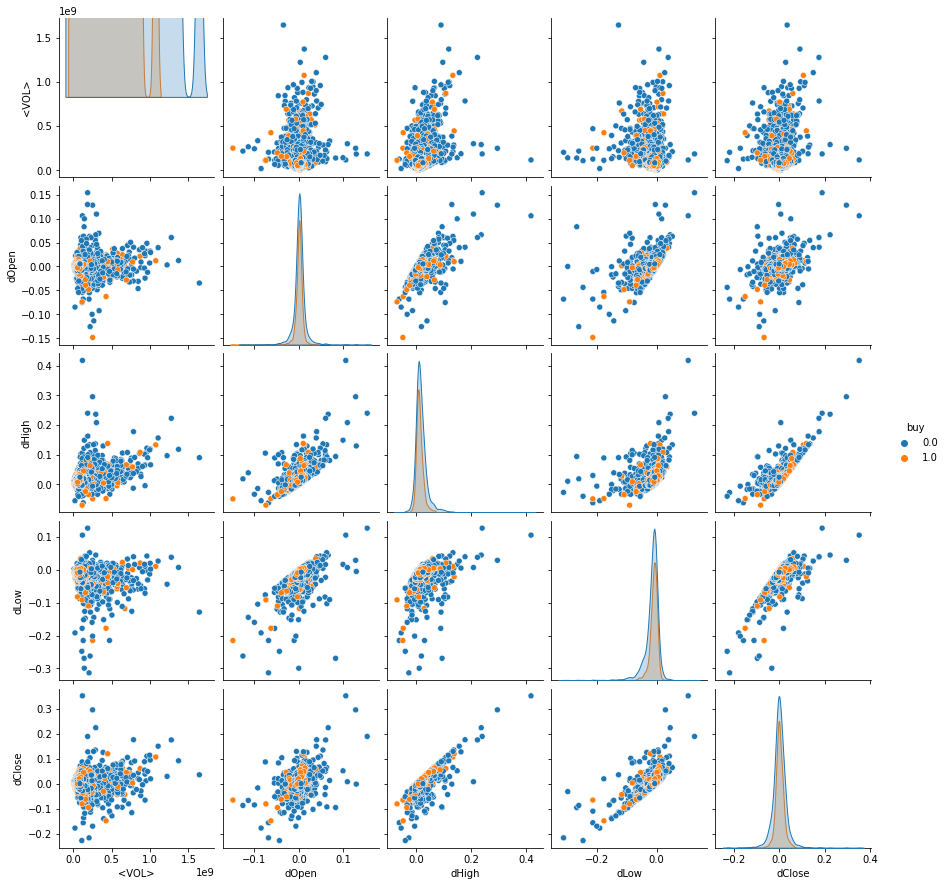

In [ ]:
data['buy'] = b
data['sell'] = s
snb.pairplot(data[['<VOL>','dOpen','dHigh','dLow','dClose','buy']],hue='buy')

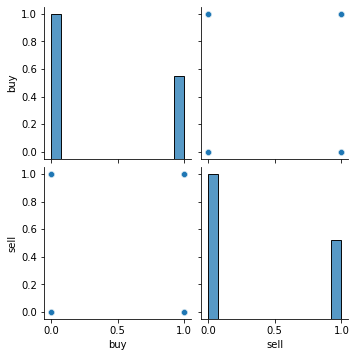

In [ ]:
snb.pairplot(data[['buy','sell']])

In [ ]:
dTP_array = np.linspace(0.001,0.05,15)
dSL_array = np.linspace(0.005,0.01,15)

ohlc = data.values[:,:4]

buyQuality = np.zeros((len(dTP_array),len(dSL_array)))
sellQuality = np.zeros((len(dTP_array),len(dSL_array)))

for n in range(len(dTP_array)):
    dTP = dTP_array[n]
    for k in range(len(dSL_array)):
        dSL = dSL_array[k]

        b,s = getBuySellForData(ohlc,dSL=dSL,dTP=dTP,orderLifeLen=10)
        
        buyQuality[n,k] = (np.sum(b)*dTP-np.sum(1-b)*dSL)/len(b)
        sellQuality[n,k] = (np.sum(s)*dTP-np.sum(1-s)*dSL)/len(s)


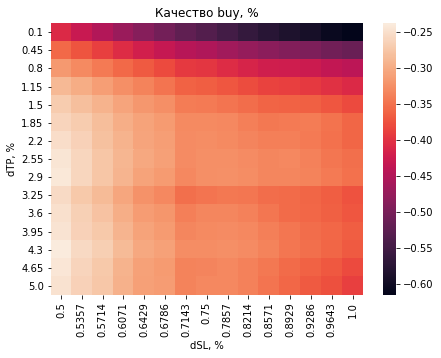

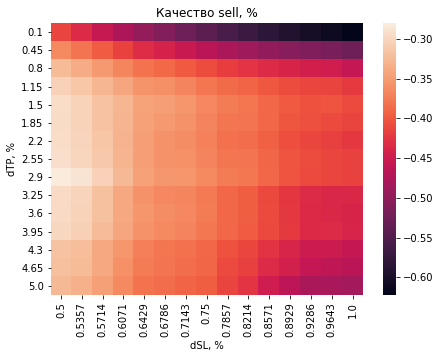

In [ ]:
plt.figure(figsize=(7,5))
snb.heatmap(100*buyQuality,xticklabels=(100*dSL_array).round(4),yticklabels=(100*dTP_array).round(4))
plt.xlabel('dSL, %')
plt.ylabel('dTP, %')
plt.title('Качество buy, %')
plt.show()

plt.figure(figsize=(7,5))
snb.heatmap(100*sellQuality,xticklabels=(100*dSL_array).round(4),yticklabels=(100*dTP_array).round(4))
plt.xlabel('dSL, %')
plt.ylabel('dTP, %')
plt.title('Качество sell, %')
plt.show()

# Поиск гиперпараметров

## Целевая функция

In [6]:
%%time

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix,f1_score

valLen = 0.2        # глубина/доля валидации для генетики
orderLifeLen = 50   # срок жизни ордера



def getQualityMethod(lookback,  # окно задержки
                     reg,       # коэффициент ругуляризации
                     min_delta, # минимальная дельта
                     lr,        # скорость обучения
                     hl,        # размер скрытого слоя
                     doRate,    # дропаут
                     dTPSL):    # доля для профит и стоп-лос
    
    reg = np.power(10,reg)
    min_delta = np.power(10,min_delta)
    lr = np.power(10,lr)

    # echo = lambda n,v: print(n,':',np.unique(v,return_counts=True))

    # подготовка сигналов
    b,s = getBuySellForData(ohlc,orderLifeLen=orderLifeLen,dSL=dTPSL,dTP=dTPSL)

    # подготовка входов
    X = np.hstack([data[['dOpen','dHigh','dLow','dClose']].shift(n) for n in range(lookback)])
    # y = np.vstack([b,s]).T
    y = b*2+s

    # отбор реальных значений
    idx = ~np.any(np.isnan(X),axis=1)
    X = X[idx]
    y = y[idx]

    # разделение выборок
    try:
        X_learn, X_valid, y_learn, y_valid = train_test_split(X,y,shuffle=True,test_size=valLen,stratify=y)
    except Exception:
        return -dSL
    
    # нормализация
    sModel = StandardScaler()
    sModel.fit(X_learn)

    X_learn = sModel.transform(X_learn)
    X_valid = sModel.transform(X_valid)

    # веса классов в обучении

    class_weights = dict(zip(np.unique(y_learn), compute_class_weight('balanced', np.unique(y_learn),y_learn)))

    # print(class_weights)

    # создание модели
    model = keras.Sequential([layers.Dense(hl,activation=tf.nn.relu,input_shape=(X_learn.shape[1],),kernel_regularizer=keras.regularizers.l2(reg)),
                              layers.Dropout(doRate),
                              layers.Dense(len(np.unique(y_learn)),activation=tf.nn.softmax,kernel_regularizer=keras.regularizers.l2(reg))
                              ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy',keras.metrics.sparse_categorical_crossentropy])

    # обучение модели

    X_learn_net, X_valid_net, y_learn_net, y_valid_net = train_test_split(X_learn,y_learn,shuffle=True,test_size=0.25,stratify=y_learn)

    learn_res = model.fit(X_learn_net, y_learn_net, 
                          epochs=1000,
                          # validation_split=0.25,
                          validation_data=(X_valid_net,y_valid_net),
                          verbose=False,
                          class_weight=class_weights,
                          use_multiprocessing=True,
                          callbacks=[keras.callbacks.EarlyStopping('val_sparse_categorical_crossentropy',min_delta=min_delta,patience=10,verbose=0)])

    # возвращаем точности на отборе генетики
    
    # print(model.evaluate(X_valid,y_valid))
    pred_valid = model.predict(X_valid)
    # print(np.mean(pred_valid,axis=0),np.std(pred_valid,axis=0))
    pred_valid = np.argmax(pred_valid,axis=1)
    # print('pred_valid',np.unique(pred_valid,return_counts=True))
    # print('y_valid',np.unique(y_valid,return_counts=True))

    # print(confusion_matrix(y_valid,pred_valid))
    # print(f1_score(y_valid,pred_valid,average='weighted'))

    def y2bs(y):
        s = y % 2
        b = ( y - s ) // 2
        return b,s

    num2bs = lambda num : np.array([[b,s] for b,s in zip(*y2bs(num))])
    
    def kach(PR,TR):
        return dTPSL*np.mean(PR*(2.0*TR-1.0))

    res = kach(num2bs(pred_valid),num2bs(y_valid))

    if res == 0.0:  # не нужны тупые бездействующие модели
        res = -dTPSL*2.0

    return res

res = getQualityMethod(30,-1.,-2.5,-4.,500,0.6,0.004)
print(res)

-0.0009006211180124224
CPU times: user 5.58 s, sys: 376 ms, total: 5.96 s
Wall time: 5.45 s


## Создание модели

### Создание

In [7]:
modelGA = ListGenetic(pop_size = 200,
                      lookback = range(10,300),
                      reg = np.round(np.arange(-7.0,-0.5,0.01),2),
                      min_delta = np.round(np.arange(-7.0,-0.5,0.01),2),
                      lr = np.round(np.arange(-7.0,-0.1,0.01),2),
                      hl = range(10,1000),
                      doRate = np.round(np.arange(0.01,1.0,0.01),2),
                      dTPSL = np.round(np.arange(0.0001,0.01,0.0001),4),
                      quality_method=getQualityMethod)

### или загрузка с диска

In [8]:
fn = '/content/drive/My Drive/prog/model_tpo_19.12.2020.pkl'

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл обучения

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

2029 {'quality': -1.9543973941368076e-06, 'lookback': 179, 'reg': -6.62, 'min_delta': -2.11, 'lr': -2.96, 'hl': 804, 'doRate': 0.05, 'dTPSL': 0.0008}
finish -  2030 {'quality': -4.754358161648177e-07, 'lookback': 93, 'reg': -3.54, 'min_delta': -2.47, 'lr': -3.12, 'hl': 888, 'doRate': 0.16, 'dTPSL': 0.0006}
2038 {'quality': -0.0018, 'lookback': 167, 'reg': -6.72, 'min_delta': -1.8, 'lr': -2.91, 'hl': 840, 'doRate': 0.12, 'dTPSL': 0.0009}
finish -  2040 {'quality': -2.195121951219512e-06, 'lookback': 174, 'reg': -4.0, 'min_delta': -1.93, 'lr': -2.74, 'hl': 852, 'doRate': 0.16, 'dTPSL': 0.0009}
2049 {'quality': -6.299212598425197e-07, 'lookback': 77, 'reg': -4.02, 'min_delta': -2.25, 'lr': -2.7, 'hl': 887, 'doRate': 0.03, 'dTPSL': 0.0008}
finish -  2050 {'quality': -3.2362459546925567e-06, 'lookback': 161, 'reg': -4.32, 'min_delta': -2.12, 'lr': -2.74, 'hl': 870, 'doRate': 0.05, 'dTPSL': 0.0008}
2059 {'quality': -8.730158730158731e-07, 'lookback': 99, 'reg': -6.76, 'min_delta': -1.6, 'lr'

## Графики

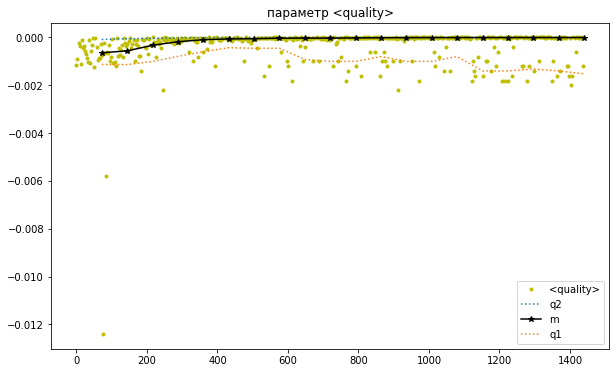

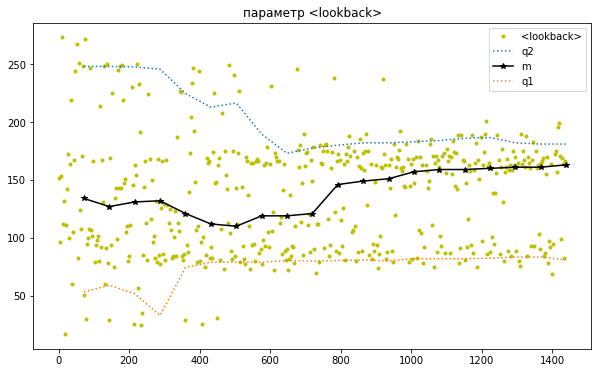

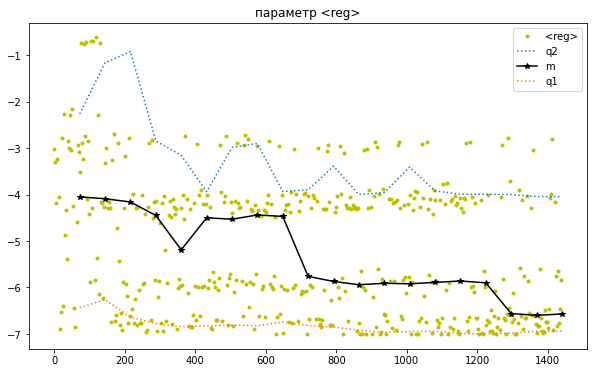

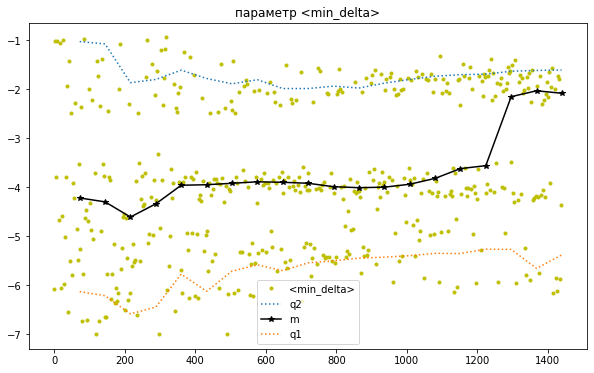

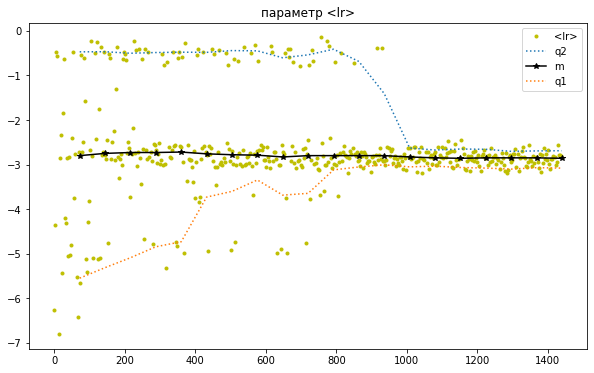

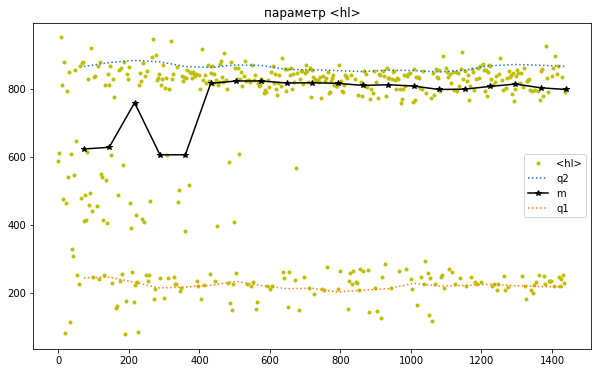

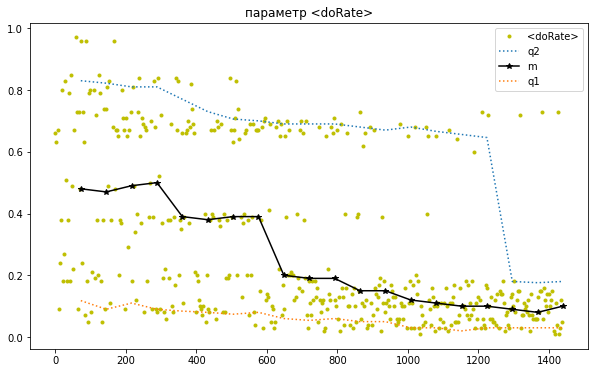

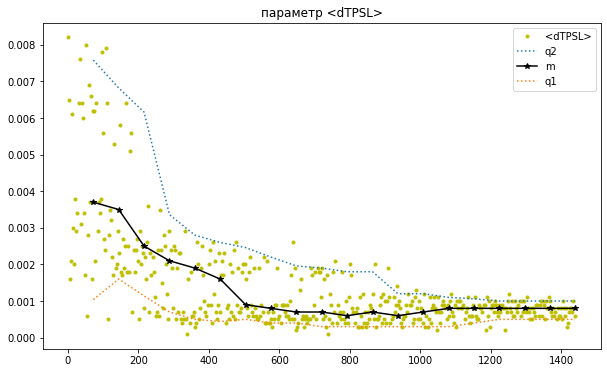

In [ ]:
modelGA.plot_hist_new(('quality','lookback','reg','min_delta','lr','hl','doRate','dTPSL'))

In [20]:
for n,h in enumerate(modelGA._hist):
    if h['new']['quality'] > 0:
        print(n,h['new'])


1354 {'quality': 6.379585326953749e-07, 'lookback': 113, 'reg': -6.84, 'min_delta': -5.89, 'lr': -2.77, 'hl': 778, 'doRate': 0.14, 'dTPSL': 0.0008}
1460 {'quality': 6.31911532385466e-07, 'lookback': 83, 'reg': -5.71, 'min_delta': -1.66, 'lr': -3.07, 'hl': 211, 'doRate': 0.03, 'dTPSL': 0.0008}
2087 {'quality': 7.281553398058253e-07, 'lookback': 158, 'reg': -3.99, 'min_delta': -1.83, 'lr': -2.88, 'hl': 866, 'doRate': 0.12, 'dTPSL': 0.0009}
2536 {'quality': 8.744038155802863e-07, 'lookback': 106, 'reg': -6.9, 'min_delta': -1.74, 'lr': -2.96, 'hl': 885, 'doRate': 0.16, 'dTPSL': 0.0011}
3886 {'quality': 7.109004739336492e-07, 'lookback': 85, 'reg': -3.93, 'min_delta': -1.33, 'lr': -3.0, 'hl': 858, 'doRate': 0.06, 'dTPSL': 0.0009}
4006 {'quality': 7.086614173228346e-07, 'lookback': 74, 'reg': -3.93, 'min_delta': -2.22, 'lr': -2.92, 'hl': 884, 'doRate': 0.06, 'dTPSL': 0.0009}
4088 {'quality': 7.131537242472266e-07, 'lookback': 94, 'reg': -6.63, 'min_delta': -2.13, 'lr': -3.0, 'hl': 938, 'doRa

## Параметры лучшей

In [ ]:
best_par = modelGA.getBestParams()
best_par

{'dTPSL': 0.0039,
 'doRate': 0.5,
 'hl': 603,
 'lookback': 143,
 'lr': -2.84,
 'min_delta': -4.09,
 'reg': -3.94}

# Отчет по модели